# Seaweed Farming Suitability Mapping


## Background
This notebook is an implementation of the method developed by Hasyim et al (2012)
and Ushanthan, Herath, and Sanjaya (2021)for identifying suitable locations for seaweed cultivation.

This notebook will produce a imagary classifying the suitability of a location for seaweed cultivation.

The sea surface tempreture function is included but is currently not functioning due to the lack of required data.



The Total Suspended Solids functions calculated by Band Ration and Normalized Suspended Material Index will. 
This notebook will produce a map for each time step with the results classified against the target criteria. 



In [ ]:
### this imports the packages required by the notebook 

In [97]:
import datacube
from odc.ui import with_ui_cbk

import numpy as np 

import matplotlib
import matplotlib.pyplot as plt

from datacube.utils.masking import make_mask
from datacube.utils.masking import mask_invalid_data
from odc.algo import mask_cleanup

from dea_tools.app import animations

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from dea_tools.plotting import display_map

In [ ]:
####This connects to the Datacube database

In [4]:
dc = datacube.Datacube(app='Seaweed Farming Suitability Mapping')

In [ ]:
####this is the geographic and time variables which will be used.

In [107]:
lat_range = (-38.75, -38.77)
lon_range = (146.78, 146.80)
time_range = ("2021-01", "2022-01")

In [108]:
####This displays a map of the geographic extent being searched

In [109]:
display_map(x=lon_range, y=lat_range)


In [ ]:
#### this is a reusable query which determins the measurments being used, the coordinates reference system used and the pixel size

In [66]:
query = {
    "x": (146.78, 146.80),
    "y": (-38.75, -38.77),
    "time": time_range ,
    "measurements": [
        "nbart_blue",
        "nbart_green",
        "nbart_red",
        "oa_fmask"
    ],      
    "output_crs": "EPSG:3577",
    "resolution": (-20, 20),
    "group_by": "solar_day",
}



In [ ]:
#### this loads the : Geoscience Australia Landsat 8 Operational Land Imager and Thermal Infra-Red Scanner Analysis Ready Data Collection 3 for the above query
this data has been geographically and radiometrically corrected which significantly reduces the required processing.

In [67]:
dsLS = dc.load(product='ga_ls8c_ard_3',
                progress_cbk=with_ui_cbk(),
                **query)
dsLS

<xarray.Dataset>
Dimensions:      (time: 25, y: 121, x: 101)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-09T23:57:53.612320 ... 2022-01...
  * y            (y) float64 -4.312e+06 -4.312e+06 ... -4.314e+06 -4.314e+06
  * x            (x) float64 1.294e+06 1.294e+06 ... 1.296e+06 1.296e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) int16 202 204 204 204 206 ... 6753 6543 6543 6772
    nbart_green  (time, y, x) int16 108 101 105 105 102 ... 6671 6602 6602 6881
    nbart_red    (time, y, x) int16 2 3 5 5 4 4 ... 7023 6834 6712 6712 7000
    oa_fmask     (time, y, x) uint8 5 5 5 5 5 5 5 5 5 5 ... 2 2 2 2 2 2 2 2 2 2
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
#### this displays the cloud cover mask for the 

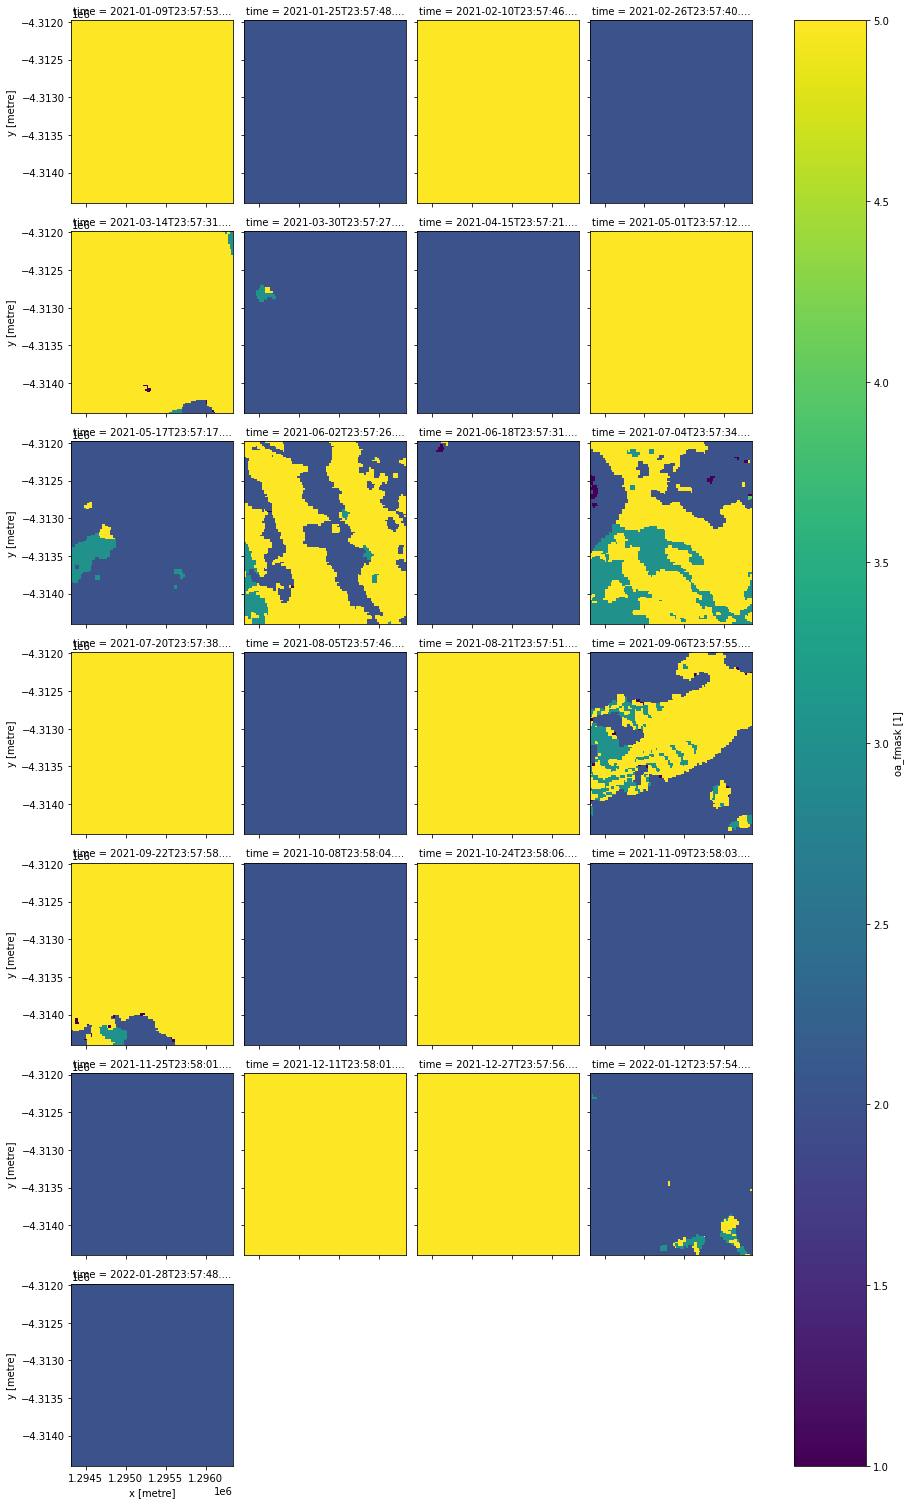

In [104]:
dsLS.oa_fmask.plot(col='time',col_wrap=4)

In [ ]:
####These two cells create a mask of water and apply it the the datacube, effectivly removing the clouds from the image.

In [69]:
cloud_free_mask = (
    make_mask(dsLS.oa_fmask, fmask="water") 
)

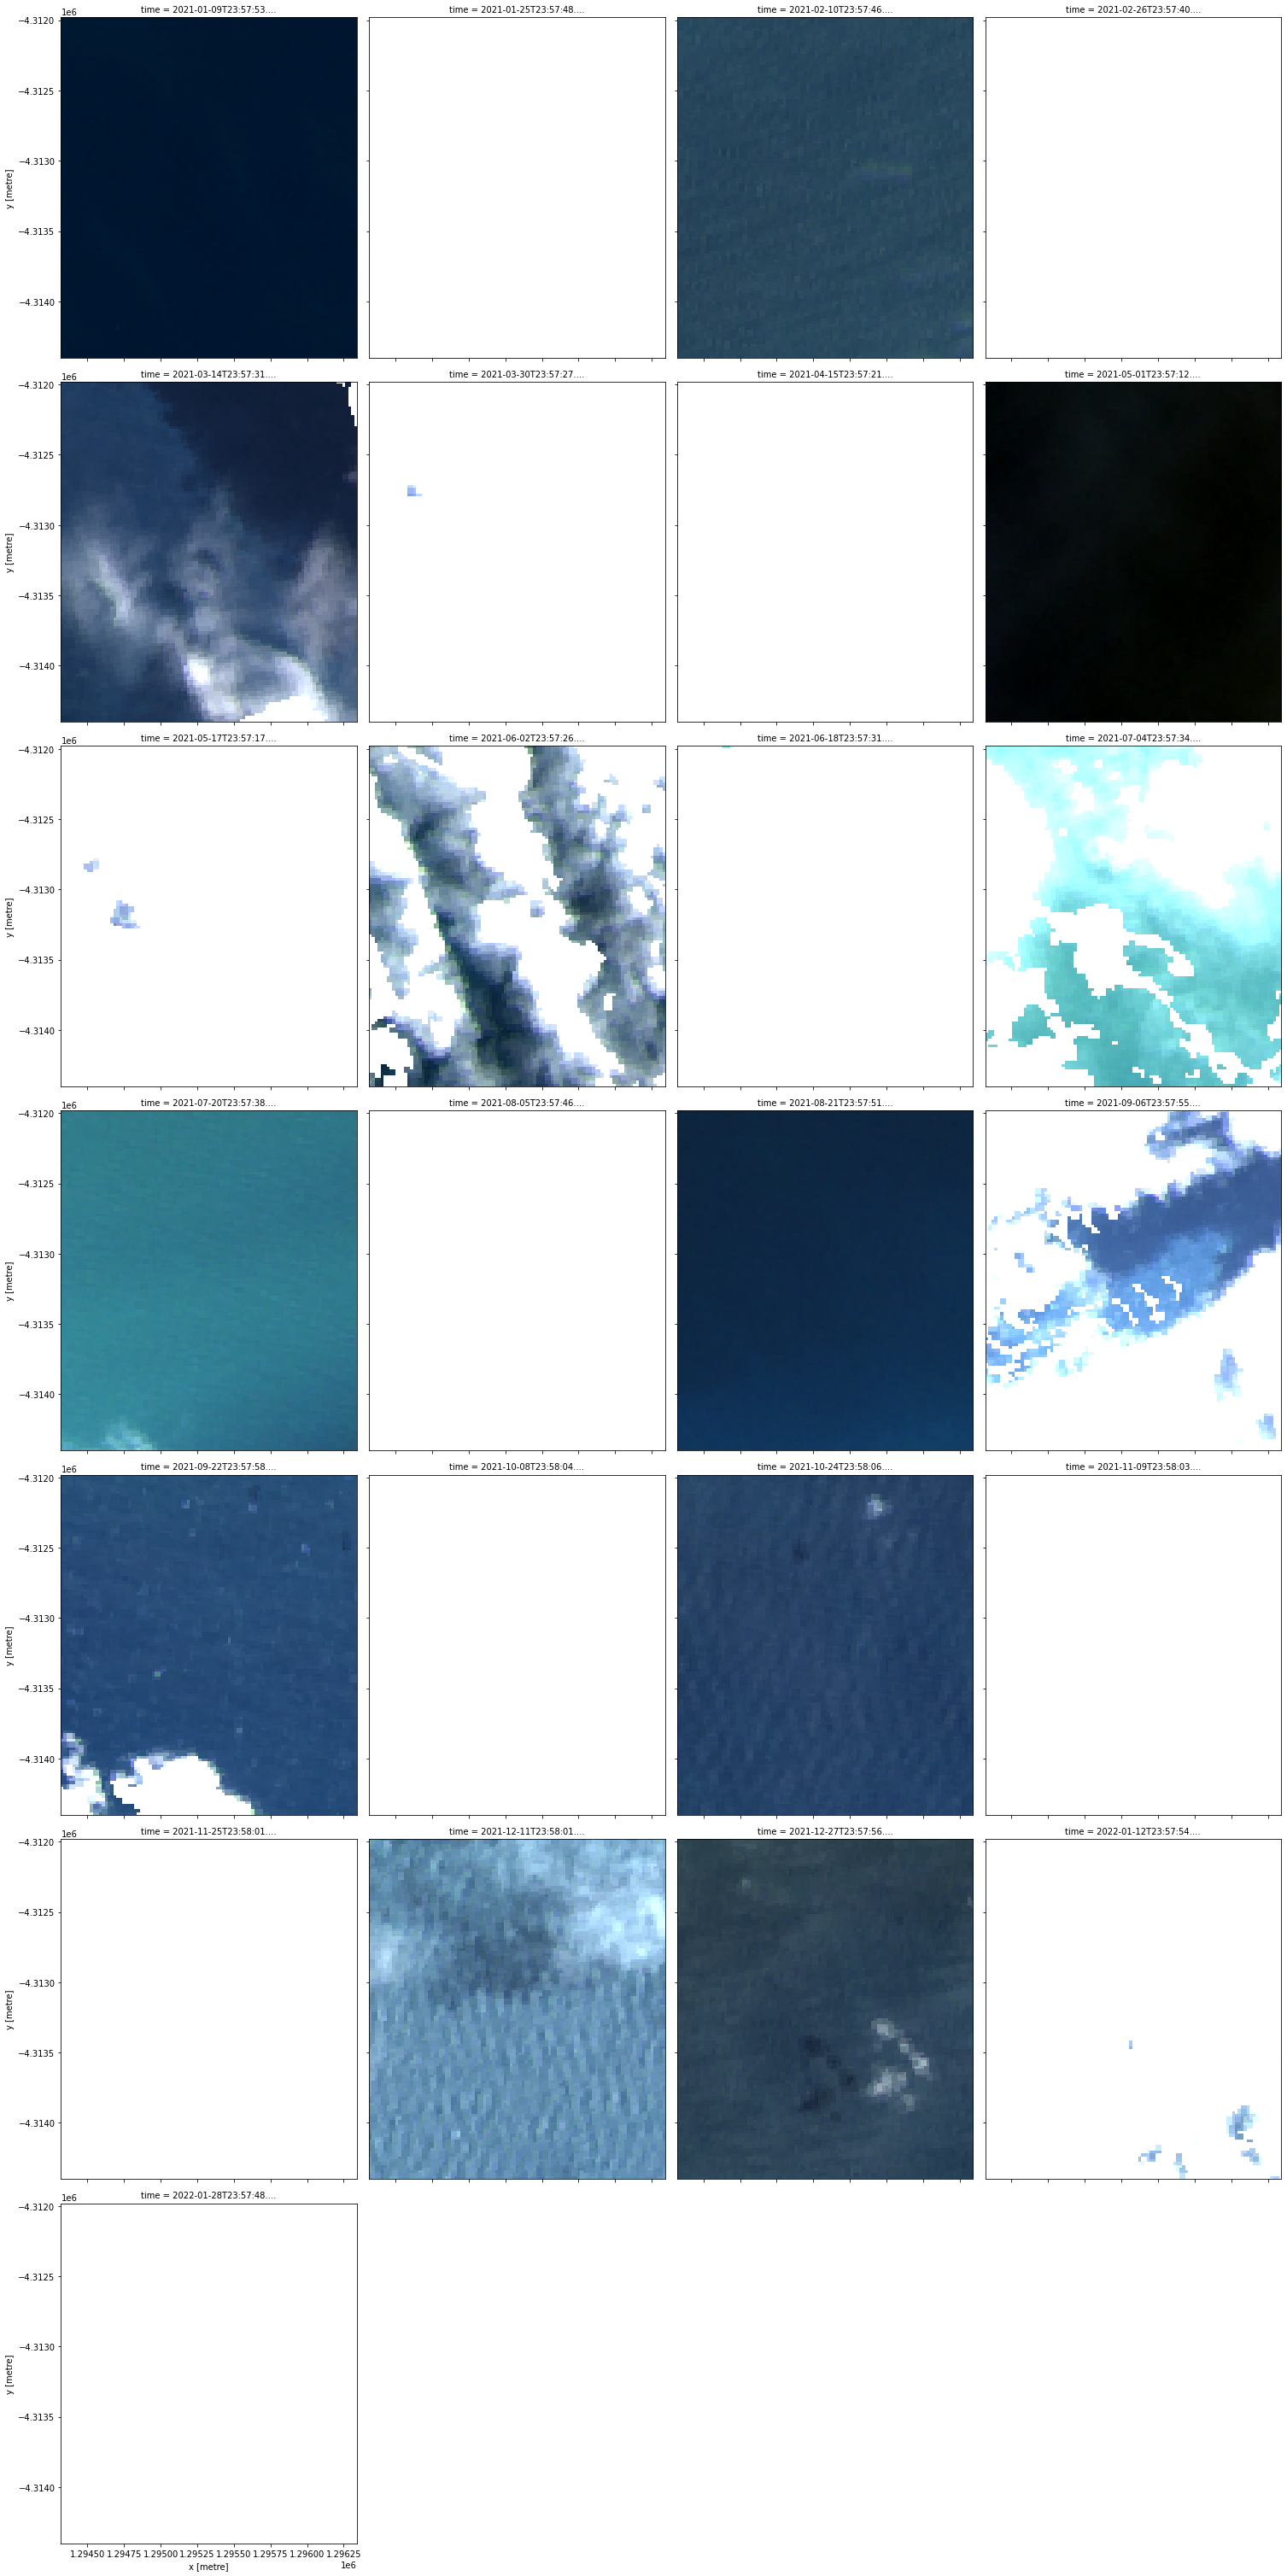

In [70]:
cloud_free = dsLS.where(cloud_free_mask)
rgb(cloud_free, col="time")

In [ ]:
#### these two cells create a index of the ratio of green to blue light, classify it against the target criteria and displays it, with 3rd class as red, 2nd class as pink and 1st class as blue.

In [71]:
cloud_free['BandRatio'] = cloud_free.nbart_green/dsLS.nbart_blue
cloud_free['BandRatio1'] = cloud_free['BandRatio']  >= .926
cloud_free['BandRatio1'] = cloud_free['BandRatio1']*124
cloud_free['BandRatio2'] = cloud_free['BandRatio']  >= 1.046 
cloud_free['BandRatio2'] = cloud_free['BandRatio2']*124
cloud_free['BandRatio3'] = cloud_free['BandRatio']  < 1.046
cloud_free['BandRatio3'] = cloud_free['BandRatio3']*124

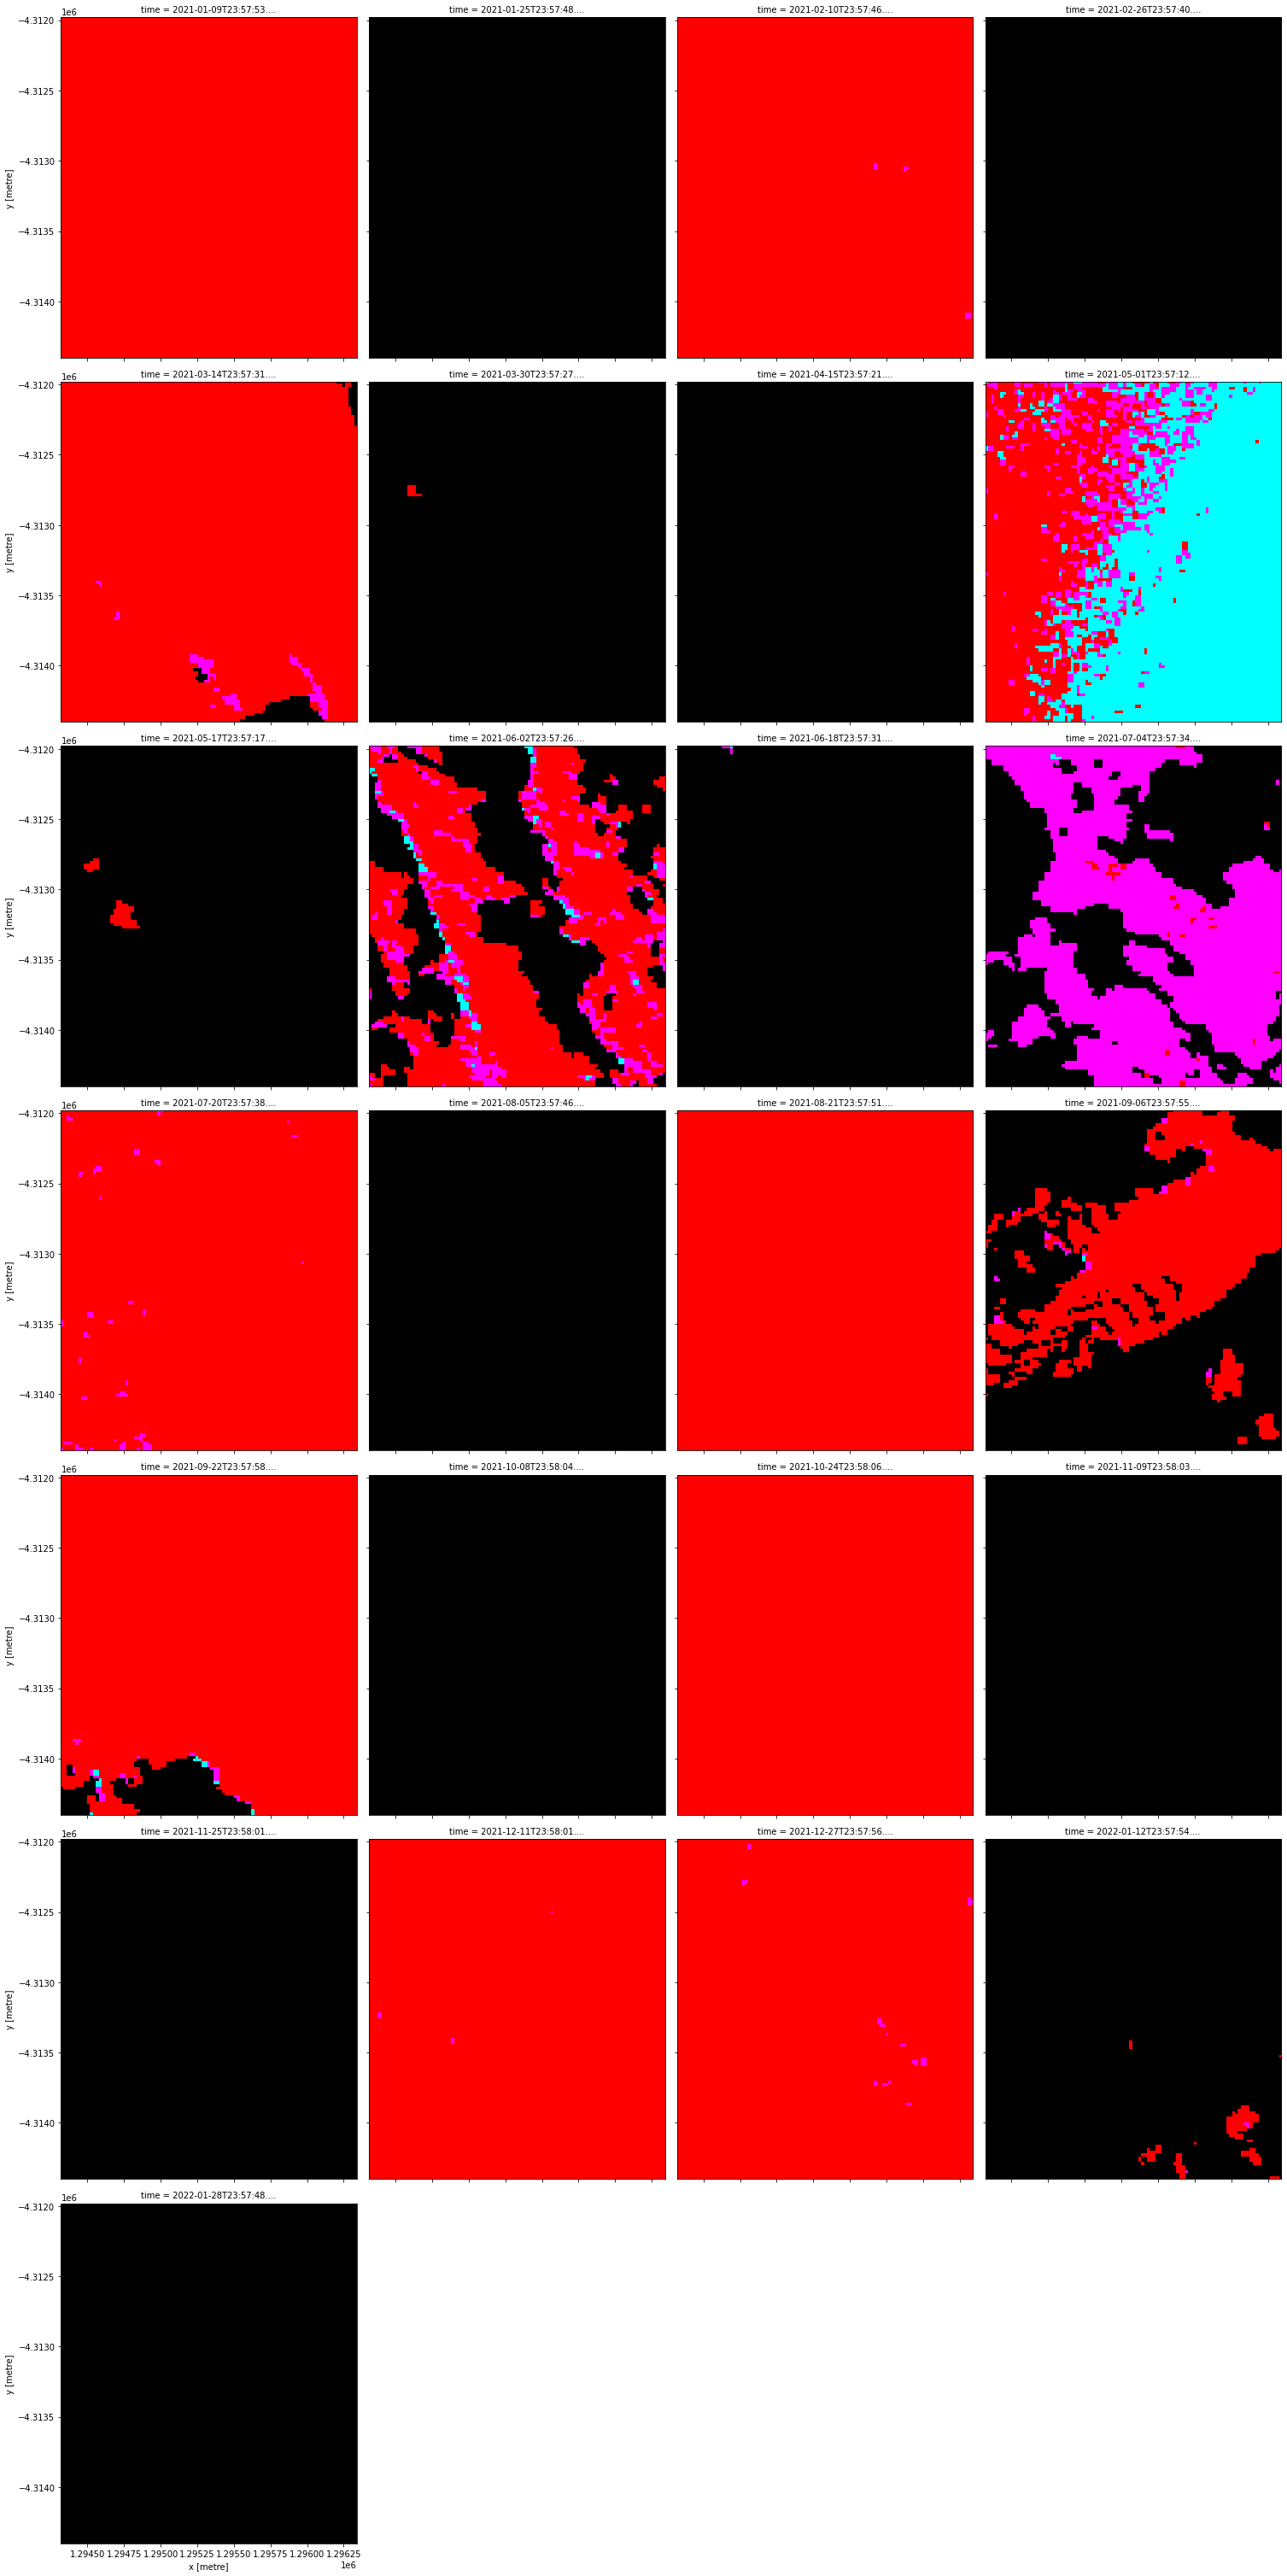

In [72]:
rgb(cloud_free, bands =['BandRatio3','BandRatio2', 'BandRatio1'], col='time')

In [ ]:
#### this shows the band ratio results without the classification.

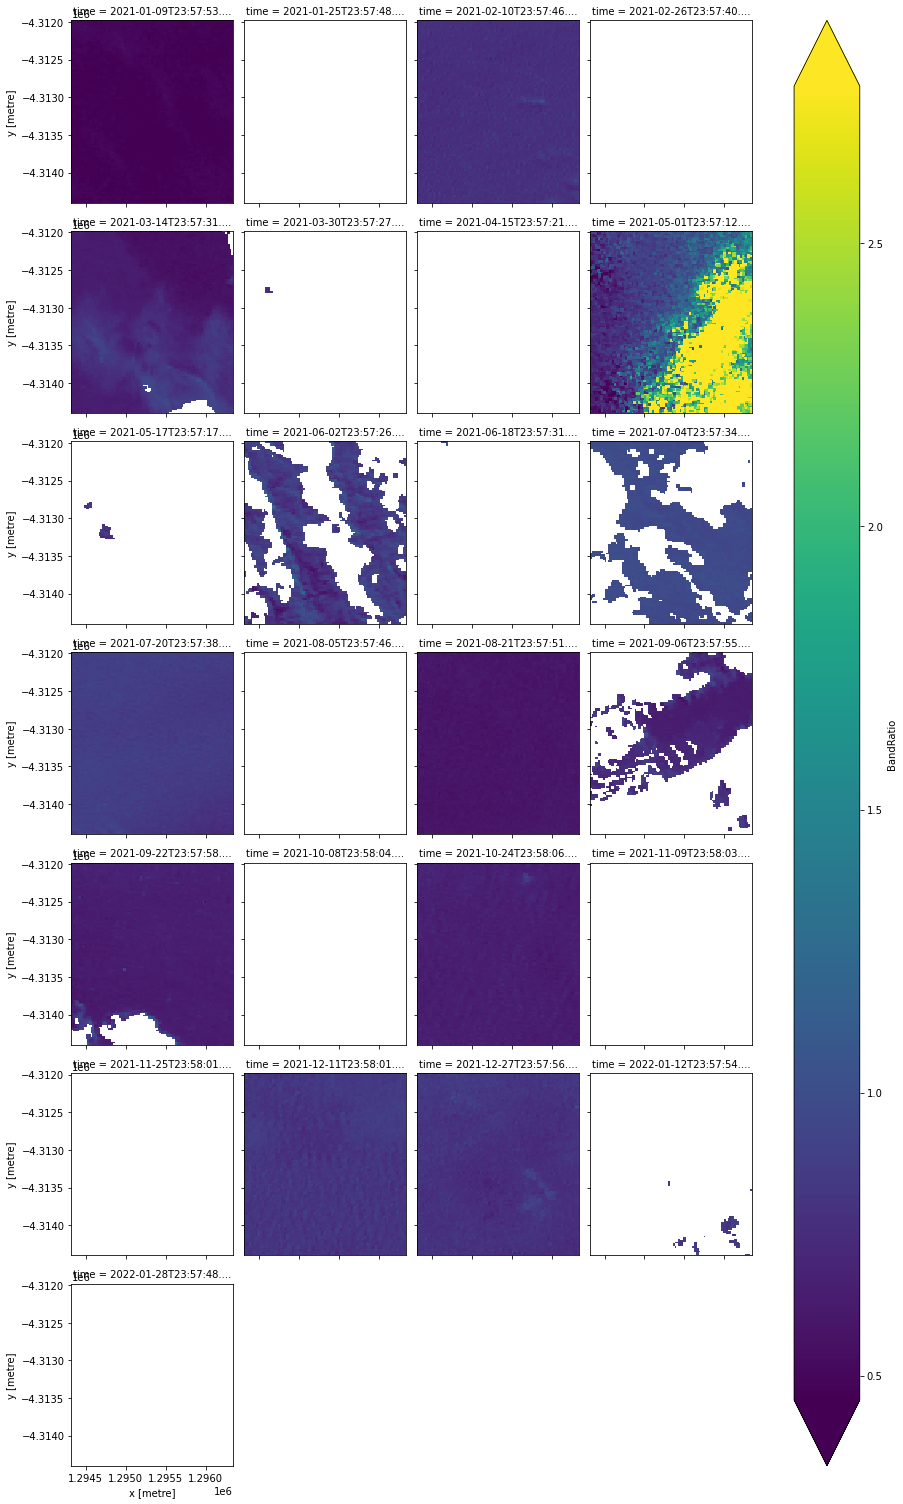

In [102]:
cloud_free.BandRatio.plot(col="time", robust=True, col_wrap=4) 

In [ ]:
#### these two cells create the Normalised Suspended Matter Index and displays the result

In [90]:
a= (cloud_free.nbart_green+cloud_free.nbart_red-cloud_free.nbart_blue)
b= (cloud_free.nbart_green+cloud_free.nbart_red+cloud_free.nbart_blue)
cloud_free['NSMI'] = a/b


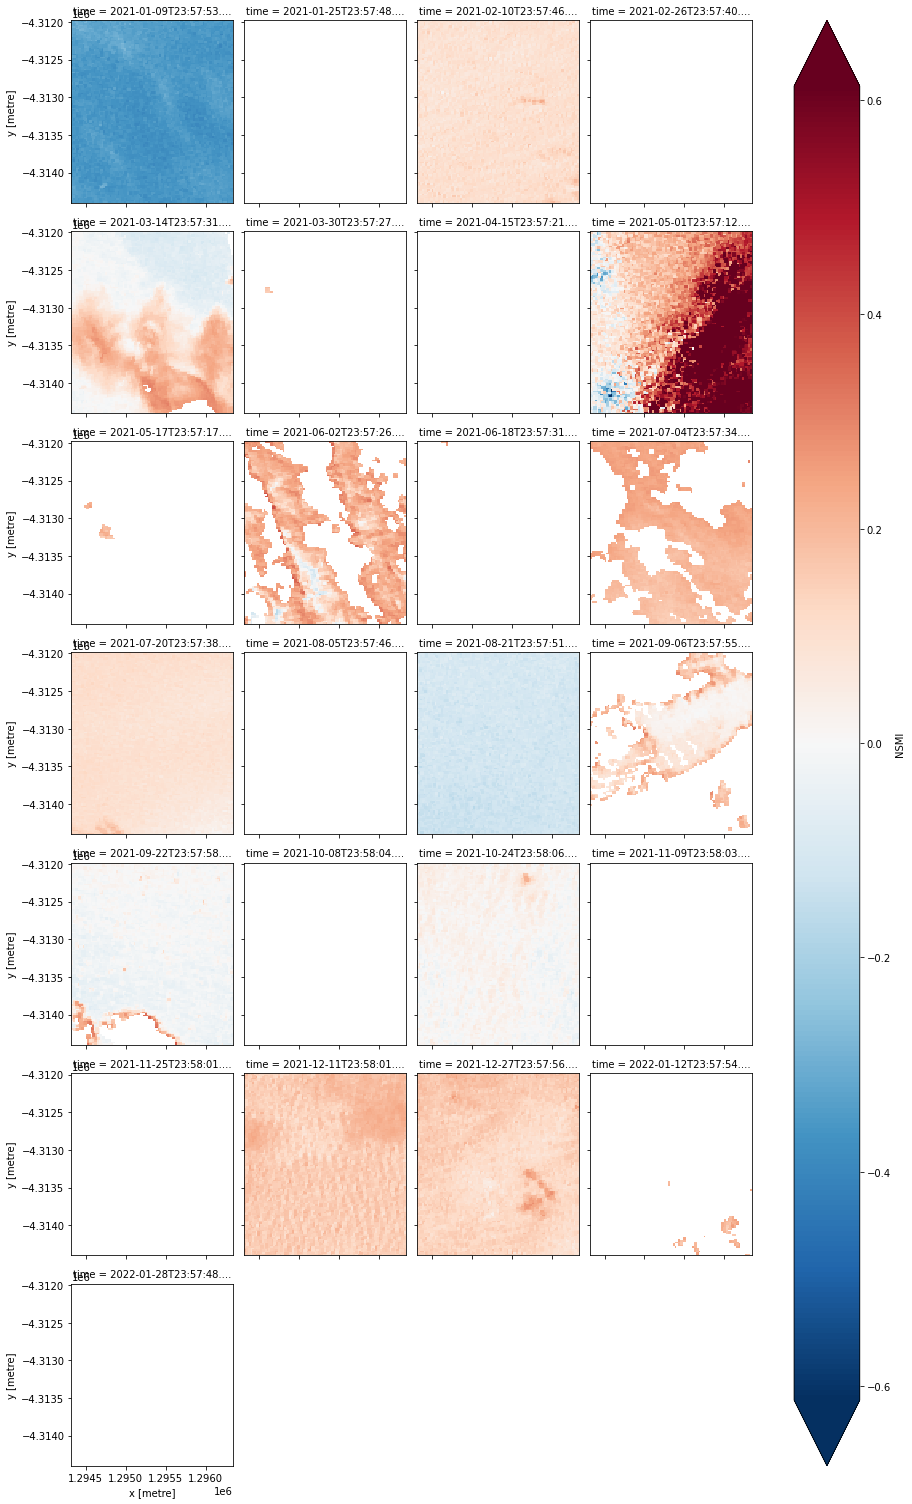

In [103]:
cloud_free.NSMI.plot(col='time', robust=True, col_wrap=4)

#### these cells classify the NSMI results and displays them, not the similarities to the band ratio results

In [76]:
cloud_free['NSMI1'] = cloud_free['NSMI']  >= .21
cloud_free['NSMI1'] = cloud_free['NSMI1']*124
cloud_free['NSMI2'] = cloud_free['NSMI']  >= .272
cloud_free['NSMI2'] = cloud_free['NSMI2']*124
cloud_free['NSMI3'] = cloud_free['NSMI']  < .272
cloud_free['NSMI3'] = cloud_free['NSMI3']*124

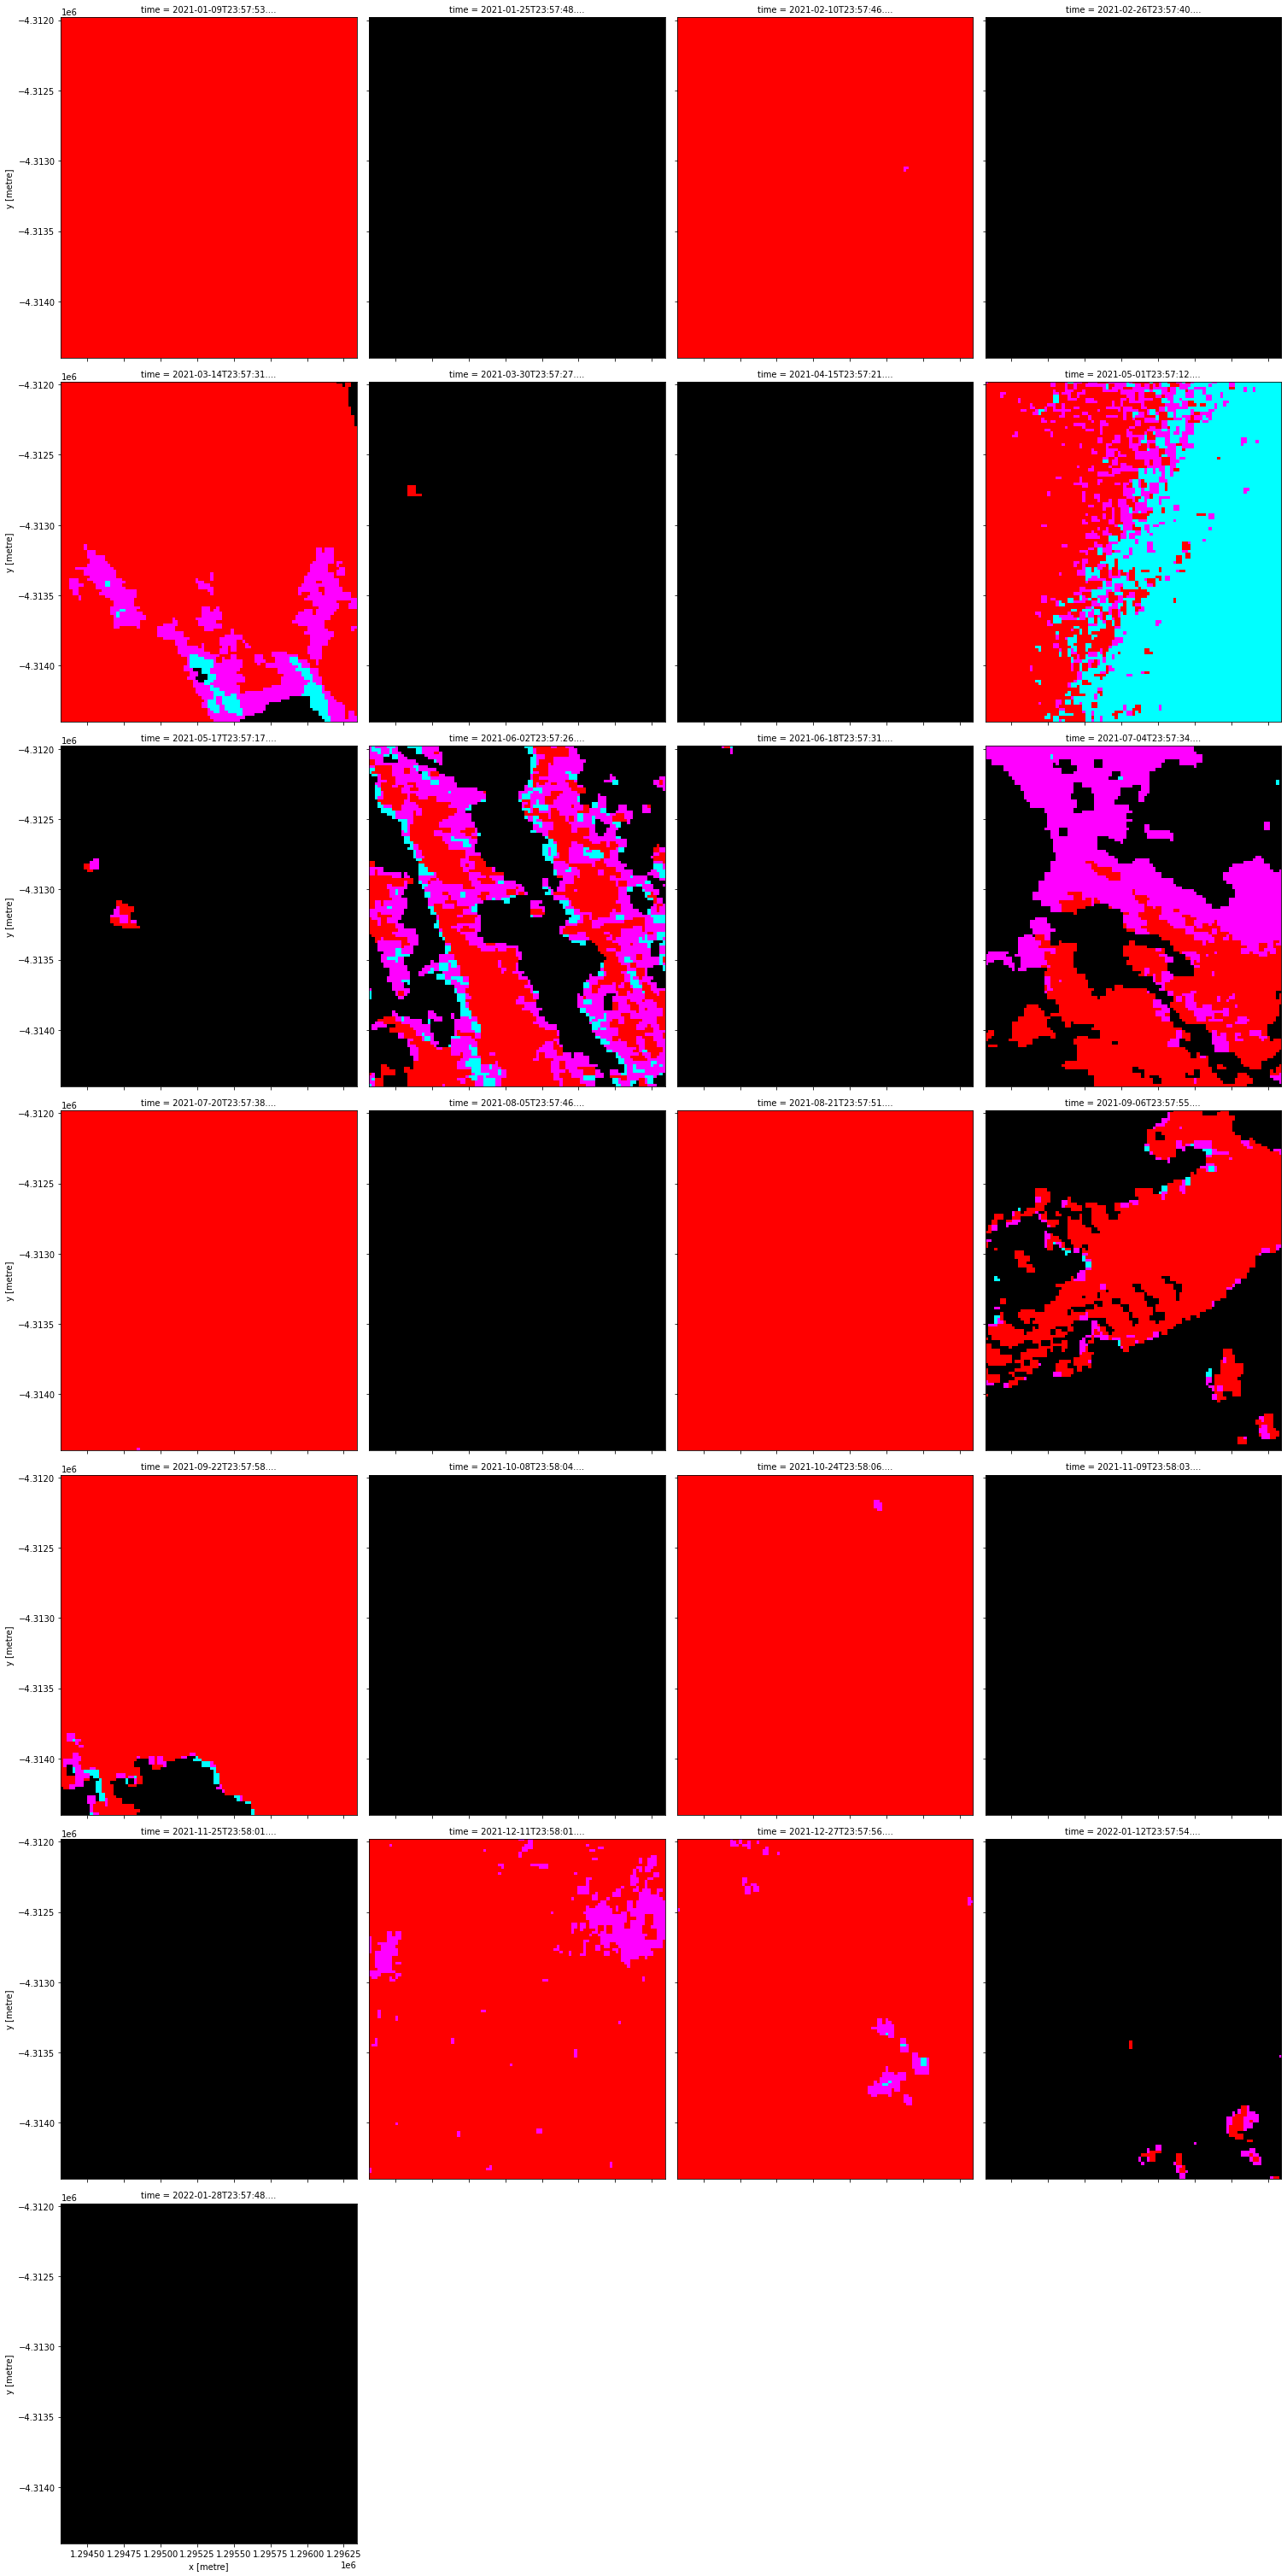

In [77]:
rgb(cloud_free, bands =['NSMI3','NSMI2', 'NSMI1'], col='time')

In [ ]:
#### the below cells show the graphical representation of the above results not the significant similarity between the two graphs

In [95]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

area_per_pixel = pixel_length**2 / m_per_km**2

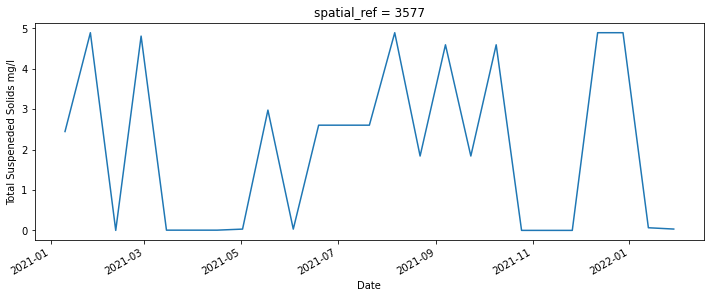

In [101]:


# Calculate the total water area (in km^2)
TotalSuspenededSolids = (
    cloud_free['NSMI'].count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
)

# Plot the resulting water area through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
TotalSuspenededSolids.plot()
axes.set_xlabel("Date")
axes.set_ylabel("Total Suspeneded Solids mg/l")
plt.show()

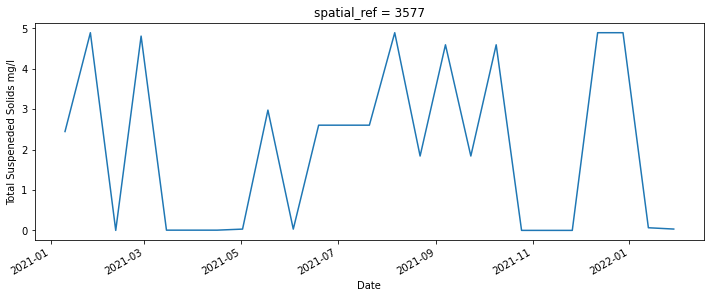

In [99]:


# Calculate the total water area (in km^2)
TotalSuspenededSolids = (
    cloud_free['BandRatio'].count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
)

# Plot the resulting water area through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
TotalSuspenededSolids.plot()
axes.set_xlabel("Date")
axes.set_ylabel("Total Suspeneded Solids mg/l")
plt.show()

In [78]:

dsLSlvl1 = dc.load(product="ga_ls8c_level1_3",
                progress_cbk=with_ui_cbk(),
                
                **query)


ValueError: No such product: ga_ls8c_level1_3

In [ ]:
cloud_free_masklvl1 = (
    make_mask(dsLSlvl1.oa_fmask, fmask="water") 
)

In [ ]:
cloud_freelvl1 = dsLS.where(cloud_free_masklvl1)
rgb(cloud_freelvl1, col="time")

In [ ]:
cloud_freelvl1['SST']= cloud_freelvl1.lwir_1 + (2.946*(cloud_freelvl1.lwir_1 - cloud_freelvl1.lwir_2)) - 0.038

cloud_freelvl1['SST']

In [ ]:
LS5 = (('LS5MAX' - 'LS5MIN')/ (255- 'DNMIN'))* ('Band6'-'DNMIN')+'LS5MIN'
TLandsat = 1260.56/ ln((607.76/ LS5)+1) – 273